# HW2 Q1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
import scipy.stats
from numpy import random
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential

In [ ]:
# calculate y
def y_func(x, L):
    return -1 + (2/3) * np.sin(2 * x * np.pi) + L

In [ ]:
def generate_data(n):
    x = 2 * np.random.random_sample((n, 1))
    L = 1.6 * np.random.random_sample((n , 1)) - 0.8
    y = y_func(x, L)
    return (x, y)

In [ ]:
# draw plot using x ,y , and title
def draw_plot(x, y, title, pred=None):
    plt.scatter(x, y, c="b")
    if (pred is not None):
        plt.scatter(x, pred, c="r")
        plt.legend(["truth", "prediction"], loc ="lower right")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

In [ ]:
rbf_train_x, rbf_train_y = generate_data(300)
rbf_valid_x, rbf_valid_y = generate_data(30)

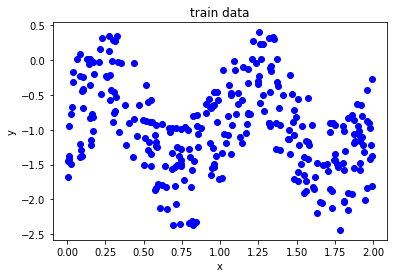

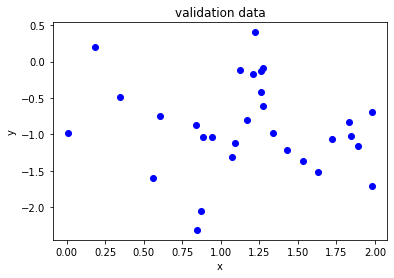

In [ ]:
draw_plot(rbf_train_x, rbf_train_y, "train data")
draw_plot(rbf_valid_x, rbf_valid_y, "validation data")

## RBF

In [ ]:
class RBF:
    def __init__(self, input_n, lr=0.01, cluster_method="kmeans"):
        self.input_n = input_n
        self.clusters_n = input_n // 2
        self.lr = lr
        # output layer weights
        self.w = np.random.random((self.clusters_n,1))
        self.b = np.random.random((1,1))
        self.cluster_method = cluster_method
        
    def find_centers_knn(self, inputs):
        clusters = KMeans(n_clusters=self.clusters_n).fit(inputs)
        return clusters.cluster_centers_

    def find_centers_random(self, inputs):
      # choose random center vectors from training set
        rnd_idx = random.permutation(len(inputs))[:self.clusters_n]
        centers = [inputs[i] for i in rnd_idx]
        return np.array(centers)

    def find_centers_gmm(self, inputs):
        gmm = GaussianMixture(n_components=self.clusters_n)
        gmm.fit(inputs)
        centers = []
        for i in range(gmm.n_components):
            density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(rbf_train_x)
            centers.append(rbf_train_x[np.argmax(density)])
        return np.array(centers)

    def gaus_dist(self, p1, p2):
        return np.abs(p1-p2)

    def rfb_layer(self, inputs):
        d = self.gaus_dist(inputs, self.centers)
        return np.exp(-d/np.power(self.rs,2))
    
    def calculate_error(self, truth, pred):
        return (np.power(truth-pred, 2)).mean()
    
    def get_result(self, inputs, truth):
        rbf_res = self.rfb_layer(inputs)
        
        output = np.dot(self.w.T, rbf_res) + self.b
        # learn output layer w and b with gradient
        if (truth is not None):
            err = (output.reshape(1,1) - truth.reshape(1,1))
            self.w = self.w - self.lr * rbf_res * err
            self.b = self.b - self.lr * err
        
        return output
            
    
    def train(self, inputs, answers, epochs, continute_train=False):
        # rbf layers radius and centers
        if (not continute_train):
            if (self.cluster_method == "kmeans"):
              self.centers = self.find_centers_knn(inputs)
            elif (self.cluster_method == "gmm"):
              self.centers = self.find_centers_gmm(inputs)
            elif (self.cluster_method == "random"):
              self.centers = self.find_centers_random(inputs)
            max_dist = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.rs = np.repeat(max_dist / np.sqrt(2*self.clusters_n), self.clusters_n)
            self.rs = np.expand_dims(self.rs, axis=1)
            
        for e in range(epochs):
            for i in range(self.input_n):
                self.get_result(inputs[i], answers[i])

    def predict(self, x):
        y = []
        for i in range(len(x)):
            y_i = self.get_result(x[i], truth=None)
            y.append(y_i)
            
        return np.array(y)

### RBF K-Means

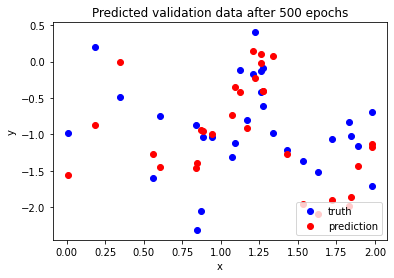

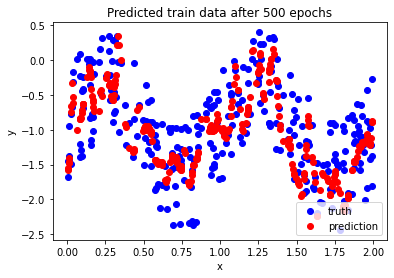

In [ ]:
rbf_kmean = RBF(len(rbf_train_x) // 2)
rbf_kmean.train(rbf_train_x, rbf_train_y, 500)

rbf_kmean_pred_valid_y = rbf_kmean.predict(rbf_valid_x).reshape((-1,1))
draw_plot(
    x=rbf_valid_x, y=rbf_valid_y, 
    pred=rbf_kmean_pred_valid_y, 
    title="Predicted validation data after 500 epochs"
)
rbf_kmean_pred_train_y = rbf_kmean.predict(rbf_train_x).reshape((-1,1))
draw_plot(
    x=rbf_train_x, y=rbf_train_y, 
    pred=rbf_kmean_pred_train_y, 
    title="Predicted train data after 500 epochs"
)

### RBF GMM

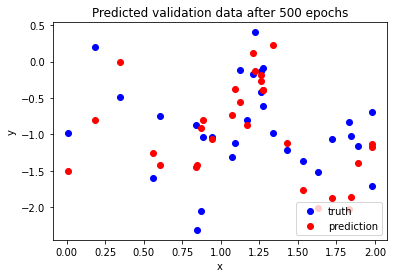

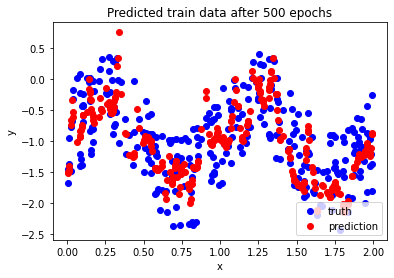

In [ ]:
rbf_gmm = RBF(len(rbf_train_x) // 2, cluster_method="gmm")
rbf_gmm.train(rbf_train_x, rbf_train_y, 500)

rbf_gmm_pred_valid_y = rbf_gmm.predict(rbf_valid_x).reshape((-1,1))
draw_plot(
    x=rbf_valid_x, y=rbf_valid_y, 
    pred=rbf_gmm_pred_valid_y, 
    title="Predicted validation data after 500 epochs"
)
rbf_gmm_pred_train_y = rbf_gmm.predict(rbf_train_x).reshape((-1,1))
draw_plot(
    x=rbf_train_x, y=rbf_train_y, 
    pred=rbf_gmm_pred_train_y, 
    title="Predicted train data after 500 epochs"
)

### RBF Random

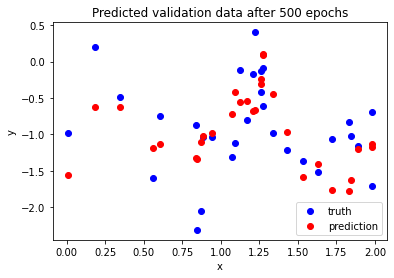

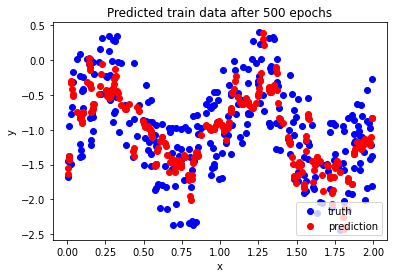

In [ ]:
rbf_random = RBF(len(rbf_train_x) // 2, cluster_method="random")
rbf_random.train(rbf_train_x, rbf_train_y, 500)

rbf_random_pred_valid_y = rbf_random.predict(rbf_valid_x).reshape((-1,1))
draw_plot(
    x=rbf_valid_x, y=rbf_valid_y, 
    pred=rbf_random_pred_valid_y, 
    title="Predicted validation data after 500 epochs"
)
rbf_random_pred_train_y = rbf_random.predict(rbf_train_x).reshape((-1,1))
draw_plot(
    x=rbf_train_x, y=rbf_train_y, 
    pred=rbf_random_pred_train_y, 
    title="Predicted train data after 500 epochs"
)

## MLP

In [ ]:
# create mlp model using the layers array
def create_mlp(layers=[60, 40, 30, 20]):
    # input layer
    input_layer = Input(shape=(None,1))
    # hidden layers
    x = Dense(layers[0])(input_layer)
    x = Activation("relu")(x)

    for i in range(1, len(layers)):
        x = Dense(layers[i])(x)
        x = Activation("relu")(x)
        
    # output layer
    x = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=x)
    model.compile(loss='mean_squared_error', optimizer='SGD')
    return model

In [ ]:
model = create_mlp()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 dense (Dense)               (None, None, 60)          120       
                                                                 
 activation (Activation)     (None, None, 60)          0         
                                                                 
 dense_1 (Dense)             (None, None, 40)          2440      
                                                                 
 activation_1 (Activation)   (None, None, 40)          0         
                                                                 
 dense_2 (Dense)             (None, None, 30)          1230      
                                                                 
 activation_2 (Activation)   (None, None, 30)          0     

In [ ]:
model.fit(
    rbf_train_x, rbf_train_y, 
    validation_data=(rbf_valid_x, rbf_valid_y), 
    epochs=1000, batch_size=50
)

Epoch 1/1000
6/6 [==============================] - 1s 53ms/step - loss: 1.0920 - val_loss: 0.7652
Epoch 2/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.8147 - val_loss: 0.5724
Epoch 3/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.6170 - val_loss: 0.4513
Epoch 4/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4869 - val_loss: 0.3945
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.4175 - val_loss: 0.3813
Epoch 6/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3883 - val_loss: 0.3860
Epoch 7/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3780 - val_loss: 0.3931
Epoch 8/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.3754 - val_loss: 0.3976
Epoch 9/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3743 - val_loss: 0.4008
Epoch 10/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3742 - val_loss: 0.4012
Epoch 11/1000
6/6 

1/1 [==============================] - 0s 205ms/step


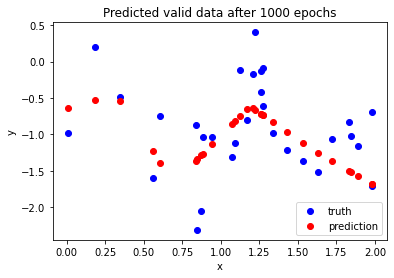

10/10 [==============================] - 0s 3ms/step


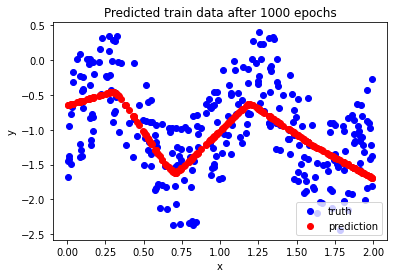

In [ ]:
mlp_pred_valid_y = model.predict(rbf_valid_x)
draw_plot(
    x=rbf_valid_x, y=rbf_valid_y, 
    pred=mlp_pred_valid_y, 
    title="Predicted valid data after 1000 epochs"
)
mlp_pred_train_y = model.predict(rbf_train_x)
draw_plot(
    x=rbf_train_x, y=rbf_train_y, 
    pred=mlp_pred_train_y, 
    title="Predicted train data after 1000 epochs"
)

## Compare Results

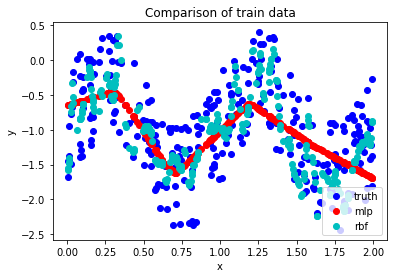

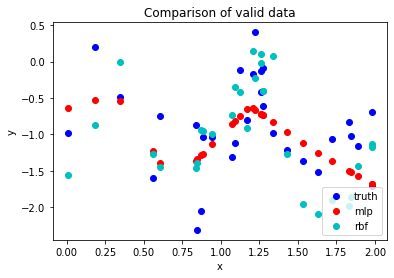

In [ ]:
plt.scatter(rbf_train_x, rbf_train_y, c="b")
plt.scatter(rbf_train_x, mlp_pred_train_y, c="r")
plt.scatter(rbf_train_x, rbf_kmean_pred_train_y, c="c")
plt.legend(["truth", "mlp", "rbf"], loc ="lower right")
plt.title("Comparison of train data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.scatter(rbf_valid_x, rbf_valid_y, c="b")
plt.scatter(rbf_valid_x, mlp_pred_valid_y, c="r")
plt.scatter(rbf_valid_x, rbf_kmean_pred_valid_y, c="c")
plt.legend(["truth", "mlp", "rbf"], loc ="lower right")
plt.title("Comparison of valid data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()